#VQA bằng phương pháp VILT(Vision and Language Transformer)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Tải training data cho fine-tuning (Bao gồm ảnh, câu hỏi và câu trả lời)

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip 'train2014.zip'
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
!unzip 'v2_Questions_Train_mscoco.zip'
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
!unzip 'v2_Annotations_Train_mscoco.zip'

Tải thư viện transformer

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Đọc câu hỏi và lưu vào biến data_question

In [ ]:
import json

# Opening JSON file
f = open('v2_OpenEnded_mscoco_train2014_questions.json')

# Return JSON object as dictionary
data_questions = json.load(f)
print(data_questions.keys())

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])


In [ ]:
questions = data_questions['questions']
questions[8]

{'image_id': 524291,
 'question': 'Is the dog waiting?',
 'question_id': 524291001}

Chúng ta tạo hàm id_from_filename để lấy id từ một bức ảnh nào đó để có thể ánh xạ vào câu hỏi

In [ ]:
import re
from typing import Optional

filename_re = re.compile(r".*(\d{12})\.((jpg)|(png))")

# source: https://github.com/allenai/allennlp-models/blob/a36aed540e605c4293c25f73d6674071ca9edfc3/allennlp_models/vision/dataset_readers/vqav2.py#L141
def id_from_filename(filename: str) -> Optional[int]:
    match = filename_re.fullmatch(filename)
    if match is None:
        return None
    return int(match.group(1))

In [ ]:
from os import listdir
from os.path import isfile, join

# root at which all images are stored
root = 'train2014'
file_names = [f for f in listdir(root) if isfile(join(root, f))]

In [ ]:
id_from_filename('COCO_train2014_000000501080.jpg')

501080

Chúng ta tạo 2 dictionary, một cái chuyển đổi tên file ảnh thành id và 1 cái ngược lại

In [ ]:
filename_to_id = {root + "/" + file: id_from_filename(file) for file in file_names}
id_to_filename = {v:k for k,v in filename_to_id.items()}

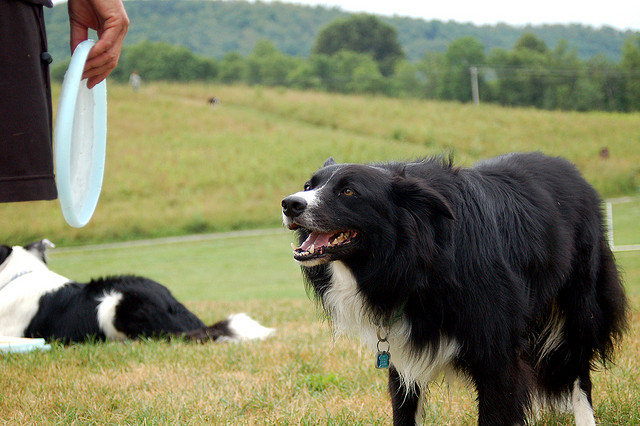

In [ ]:
from PIL import Image

path = id_to_filename[questions[8]['image_id']]
image = Image.open(path)
image



Chúng ta mở file Annotations, thấy rằng với mỗi câu hỏi chúng ta có rất nhiều lựa chọn trả lời

In [ ]:
import json
# Read annotations
f = open('v2_mscoco_train2014_annotations.json')
# Return JSON object as dictionary
data_annotations = json.load(f)
print(data_annotations.keys())

dict_keys(['info', 'license', 'data_subtype', 'annotations', 'data_type'])


In [ ]:
annotations = data_annotations['annotations']

In [ ]:
annotations[8]

{'question_type': 'is the',
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 4},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 9},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 524291,
 'answer_type': 'yes/no',
 'question_id': 524291001}

Gán nhãn và score

In [ ]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [ ]:
from tqdm.notebook import tqdm

def get_score(count: int) -> float:
    return min(1.0, count / 3)

for annotation in tqdm(annotations):
    answers = annotation['answers']
    answer_count = {}
    for answer in answers:
        answer_ = answer["answer"]
        answer_count[answer_] = answer_count.get(answer_, 0) + 1
    labels = []
    scores = []
    for answer in answer_count:
        if answer not in list(config.label2id.keys()):
            continue
        labels.append(config.label2id[answer])
        score = get_score(answer_count[answer])
        scores.append(score)
    annotation['labels'] = labels
    annotation['scores'] = scores

  0%|          | 0/443757 [00:00<?, ?it/s]

In [ ]:
annotations[8]

{'question_type': 'is the',
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 4},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 9},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 524291,
 'answer_type': 'yes/no',
 'question_id': 524291001,
 'labels': [3],
 'scores': [1.0]}

In [ ]:
scores = annotations[8]['scores']
print(scores)

[1.0]


Tiếp theo, chúng ta sẽ tạo một tập dữ liệu thông thường cho PyTorch. Chúng ta sử dụng ViltProcessor để chuẩn bị mỗi cặp hình ảnh + văn bản cho mô hình, điều này sẽ tự động thực hiện các bước sau:

Sử dụng BertTokenizerFast để tách từ văn bản và tạo input_ids, attention_mask và token_type_ids.
Sử dụng ViltFeatureExtractor để thay đổi kích thước + chuẩn hóa hình ảnh và tạo pixel_values và pixel_mask.

In [ ]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, questions, annotations, processor):
        self.questions = questions
        self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image + text
        annotation = self.annotations[idx]
        questions = self.questions[idx]
        image = Image.open(id_to_filename[annotation['image_id']])
        text = questions['question']

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        labels = annotation['labels']
        scores = annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        targets = torch.zeros(len(config.id2label))
        for label, score in zip(labels, scores):
              targets[label] = score
        encoding["labels"] = targets

        return encoding

In [ ]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

dataset = VQADataset(questions=questions[:100],
                     annotations=annotations[:100],
                     processor=processor)

Định nghĩa Model, với trọng số của phần thân mô hình được khởi tạo từ dandelin/vilt-b32-finetuned-vqa và phần đầu phân loại được khởi tạo ngẫu nhiên. Chúng ta cũng sẽ chuyển nó lên GPU nếu có sẵn.

In [ ]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa",
                                                 num_labels=len(config.id2label),
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
model.to(device)

ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

Tiếp theo, chúng ta sẽ tạo một DataLoader tương ứng trong PyTorch, cho phép chúng ta lặp qua tập dữ liệu theo các batch.

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  encoding = processor.image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([4, 40])
attention_mask torch.Size([4, 40])
token_type_ids torch.Size([4, 40])
pixel_values torch.Size([4, 3, 576, 576])
pixel_mask torch.Size([4, 576, 576])
labels torch.Size([4, 3129])


Xây dựng hàm đánh giá


In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
def flat_accuracy(preds, labels):
    new_preds = list()
    for pred in preds:
        #new_pred = [int(x) for x in pred]
        #max=np.argmax(new_pred)

        new_pred = pred
        max=new_pred[np.argmax(new_pred)]

        tmp_list = list()
        for p in new_pred:
          if p==max:
            p=1
            tmp_list.append(1)
          else:
            p=0
            tmp_list.append(0)

        new_preds.append(tmp_list)
        #new_preds.append(new_pred)
    new_labels = list()
    for label in labels:
        #new_label = [int(x) for x in label]

        new_label = label

        #max=np.argmax(new_label)
        max=new_label[np.argmax(new_label)]

        tmp_list = list()
        for p in new_label:
          if p==max:
            p=1
            tmp_list.append(1)
          else:
            p=0
            tmp_list.append(0)

        new_labels.append(tmp_list)


    preds = new_preds
    labels = new_labels

    total_accuracy = 0
    for i in range(0, len(preds)):
        total_accuracy += accuracy_score(preds[i], labels[i])
    return total_accuracy/len(preds)

In [ ]:
def flat_f1_score(preds, labels):
    new_preds = list()
    for pred in preds:
        #new_pred = [int(x) for x in pred]
        #max=np.argmax(new_pred)

        new_pred = pred
        max=new_pred[np.argmax(new_pred)]

        tmp_list = list()
        for p in new_pred:
          if p==max:
            p=1
            tmp_list.append(1)
          else:
            p=0
            tmp_list.append(0)

        new_preds.append(tmp_list)
        #new_preds.append(new_pred)
    new_labels = list()
    for label in labels:
        #new_label = [int(x) for x in label]

        new_label = label

        #max=np.argmax(new_label)
        max=new_label[np.argmax(new_label)]

        tmp_list = list()
        for p in new_label:
          if p==max:
            p=1
            tmp_list.append(1)
          else:
            p=0
            tmp_list.append(0)

        new_labels.append(tmp_list)


    preds = new_preds
    labels = new_labels


    total_f1_score = 0
    for i in range(0, len(preds)):
        total_f1_score += f1_score(preds[i], labels[i], average='macro')
    return total_f1_score/len(preds)

Training

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
total = 0
model.train()
for epoch in range(50):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   acc_sum=0
   loss_sum=0
   f1_sum=0
   for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        y_true=batch['labels'].to('cpu').numpy()
        y_pred=outputs.logits.cpu().detach().numpy()
        acc=flat_accuracy(y_pred,y_true)
        f1=flat_f1_score(y_pred,y_true)
        loss_sum+=loss.item()
        acc_sum+=acc
        f1_sum+=f1
        loss.backward()
        optimizer.step()
   n=len(train_dataloader)
   print("Loss:", loss_sum/n,"accuracy:",acc_sum/n,"f1_score",f1_sum/n)

Epoch: 0


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 2.1711564755439756 accuracy: 0.9997954618088848 f1_score 0.8816155063134774
Epoch: 1


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 1.9561151126027108 accuracy: 0.999840204538191 f1_score 0.9119600299275679
Epoch: 2


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 1.322506191134453 accuracy: 0.9998593799936082 f1_score 0.9239648260908827
Epoch: 3


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.9784218788146972 accuracy: 0.9999041227229146 f1_score 0.9539760166274356
Epoch: 4


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.8798989650607109 accuracy: 0.9999105145413868 f1_score 0.9589776150929086
Epoch: 5


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.7868449553847313 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 6


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.7500309211015701 accuracy: 0.999910514541387 f1_score 0.9589776150929086
Epoch: 7


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.73202328145504 accuracy: 0.9999169063598592 f1_score 0.9639792135583817
Epoch: 8


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.7331282031536103 accuracy: 0.9999105145413868 f1_score 0.9589776150929085
Epoch: 9


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.8541925998777151 accuracy: 0.999910514541387 f1_score 0.9589776150929086
Epoch: 10


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.8457605619728565 accuracy: 0.9999105145413868 f1_score 0.9589776150929087
Epoch: 11


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.7575658884644508 accuracy: 0.999910514541387 f1_score 0.9589776150929086
Epoch: 12


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6950510615110397 accuracy: 0.9999105145413867 f1_score 0.9589776150929086
Epoch: 13


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6693510240316392 accuracy: 0.9999169063598593 f1_score 0.9639792135583815
Epoch: 14


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6886492851376533 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 15


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.673129600211978 accuracy: 0.999910514541387 f1_score 0.9589776150929085
Epoch: 16


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6717622571066022 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 17


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6638788610696793 accuracy: 0.9999169063598593 f1_score 0.9639792135583818
Epoch: 18


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6658763629198075 accuracy: 0.9999169063598593 f1_score 0.9639792135583817
Epoch: 19


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6484614869207144 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 20


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6808930028416217 accuracy: 0.9999169063598593 f1_score 0.9639792135583817
Epoch: 21


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6413026954978704 accuracy: 0.9999105145413871 f1_score 0.9589776150929086
Epoch: 22


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6391069320961833 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 23


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6262118777632714 accuracy: 0.9999169063598593 f1_score 0.9639792135583818
Epoch: 24


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6312049008160829 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 25


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6384319315291941 accuracy: 0.9999169063598592 f1_score 0.9639792135583817
Epoch: 26


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.635112603418529 accuracy: 0.9999169063598593 f1_score 0.9639792135583818
Epoch: 27


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6336586651206016 accuracy: 0.9999169063598593 f1_score 0.9639792135583817
Epoch: 28


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6294914248678833 accuracy: 0.9999169063598593 f1_score 0.9639792135583817
Epoch: 29


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.635275188907981 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 30


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6205679837986827 accuracy: 0.9999169063598593 f1_score 0.9639792135583818
Epoch: 31


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6225520471483469 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 32


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6273945554718375 accuracy: 0.9999169063598593 f1_score 0.9639792135583817
Epoch: 33


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6383338472805917 accuracy: 0.9999169063598593 f1_score 0.9639792135583818
Epoch: 34


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6386490574665368 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 35


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.643449867554009 accuracy: 0.9999169063598594 f1_score 0.9639792135583817
Epoch: 36


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6249397213384509 accuracy: 0.9999169063598593 f1_score 0.9639792135583815
Epoch: 37


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6266241094470024 accuracy: 0.999910514541387 f1_score 0.9589776150929086
Epoch: 38


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6337732934951782 accuracy: 0.9999169063598593 f1_score 0.9639792135583817
Epoch: 39


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6225520456768572 accuracy: 0.9999105145413868 f1_score 0.9589776150929086
Epoch: 40


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6187710548192262 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 41


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6218493116274476 accuracy: 0.9999105145413868 f1_score 0.9589776150929087
Epoch: 42


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6202993261814117 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 43


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6186276689358056 accuracy: 0.9999169063598592 f1_score 0.9639792135583817
Epoch: 44


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.616396849937737 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 45


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6242185032367706 accuracy: 0.9999169063598592 f1_score 0.9639792135583818
Epoch: 46


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6159562789089977 accuracy: 0.9999169063598592 f1_score 0.9639792135583817
Epoch: 47


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.614187326990068 accuracy: 0.9999169063598591 f1_score 0.9639792135583818
Epoch: 48


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.615185260148719 accuracy: 0.9999041227229146 f1_score 0.9539760166274353
Epoch: 49


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.6231482161674649 accuracy: 0.9999169063598593 f1_score 0.9639792135583818


Kiểm tra xem model mới được fine-tuning có hoạt động hiệu quả không

In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image

# prepare image + question
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "How many cats are there?"

# prepare inputs
inputs = processor(image, text, return_tensors="pt")
inputs = {key: value.to('cuda:0') for key, value in inputs.items()}
# forward pass
outputs = model(**inputs)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])

Predicted answer: 2
